In [16]:
import pandas as pd
import numpy as np
import sklearn as sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, label_binarize
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score, roc_auc_score, roc_curve, auc
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy.optimize import linear_sum_assignment as linear_assignment

In [21]:
df = pd.read_csv('~/Box/DSCI303/archive/final_data.csv')#.truncate(after=10000)
features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
        'liveness', 'loudness','speechiness','tempo','valence']
### Danceability, valence, liveness can be improved

In [22]:
### PCA with N Components = 2


def doPCA(df):
    pca = PCA(n_components = 2)
    X = pca.fit_transform(df[features])
    #print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    X_reduced = pd.DataFrame(X)
    X_new = pca.inverse_transform(X)
    return X_reduced, X_new

def doGMM(X_new,X_reduced, n_clus):
    gmm = GaussianMixture(n_components=n_clus).fit(X_new)
    labels = gmm.predict(X_new)
    X_reduced['labels'] = labels
    X_reduced['year_bins'] = df['year_bins']
    X_reduced['popularity_cut'] = df['popularity_cut']
    X_reduced['popularity_qcut'] = df['popularity_qcut']

    # Calculate Silhoutte and BIC Score
    ss = metrics.silhouette_score(X_new, labels, metric='euclidean')
    bic = gmm.bic(X_new)
    print('Silhouette Score: %.3f' % ss)
    print('BIC Score: %.3f' % bic)
    
    return gmm, X_reduced, ss, bic
    
def plot_gmm(gmm, X_reduced, title,  ax=None):
    labels = X_reduced['labels']
    plt.scatter(X_reduced[0], X_reduced[1], c=labels, s=3, cmap='viridis', zorder=2)
    plt.title(title)
    plt.show()
    
# X_reduced, X_new = doPCA(df)
# gmm, X_reduced, ss,bic, roc_auc= doGMM(X_new,X_reduced, n_clus=4)
# plot_gmm(gmm, X_reduced, "predicted cluster: k="+str(4))
# plot_ROC(gmm, X_reduced['year_bins'])

=========== GMM for K=2 =============
Silhouette Score: 0.433
BIC Score: -13070041.835


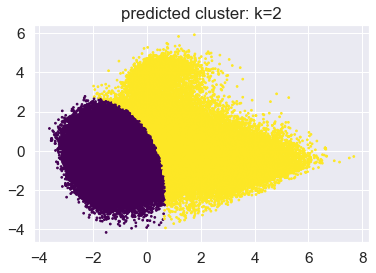

=========== GMM for K=3 =============
Silhouette Score: 0.342
BIC Score: -13089924.349


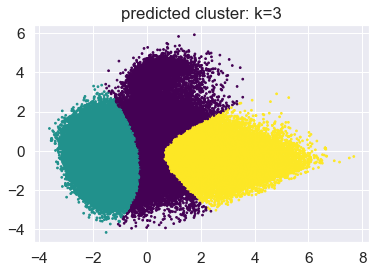

=========== GMM for K=4 =============
Silhouette Score: 0.368
BIC Score: -13092406.329


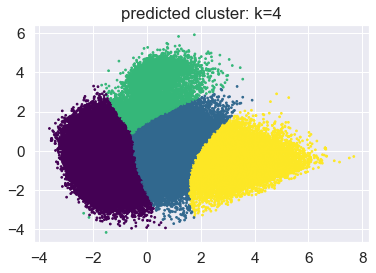

=========== GMM for K=5 =============
Silhouette Score: 0.369
BIC Score: -13094461.447


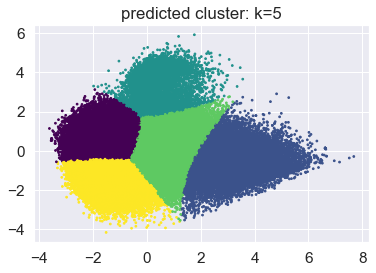

=========== GMM for K=6 =============
Silhouette Score: 0.340
BIC Score: -13095556.516


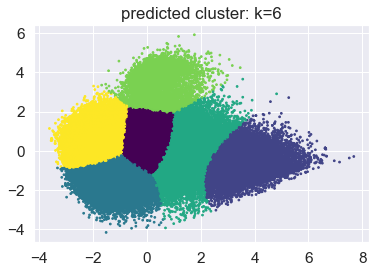

In [23]:
kvals = [2,3,4,5,6]
# kvals=[4]
sillhouette_scores =[]
bics = []
X_reduced, X_new = doPCA(df)
for k in kvals:
    print("=========== GMM for K="+str(k)+" =============")
    gmm, X_reduced, ss,bic= doGMM(X_new,X_reduced, n_clus=k)
    sillhouette_scores.append(ss)
    bics.append(bic)
    plot_gmm(gmm, X_reduced, "predicted cluster: k="+str(k))

# plot2d(X_reduced, "labels","GMM predicted clusters - k=4", color="bright")
# plot3d(X_reduced, "labels","GMM predicted clusters - k=4")

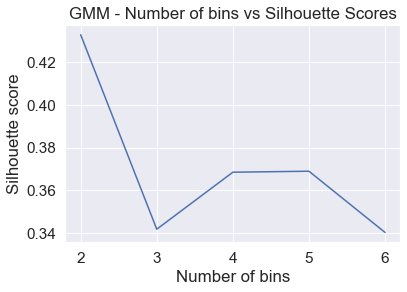

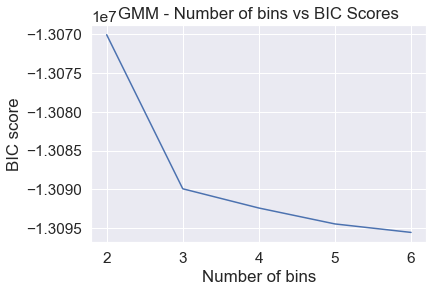

In [24]:
#Plot Silhouette and BIC scores
plt.plot(kvals, sillhouette_scores)
plt.xlabel("Number of bins")
plt.ylabel("Silhouette score")
plt.title("GMM - Number of bins vs Silhouette Scores")
plt.show()

plt.plot(kvals, bics)
plt.xlabel("Number of bins")
plt.ylabel("BIC score")
plt.title("GMM - Number of bins vs BIC Scores")
plt.show()

## Checking Accuracy

In [40]:
X_reduced, X_new = doPCA(df)
gmm, X_reduced, ss, bic = doGMM(X_new,X_reduced, n_clus=4)

Silhouette Score: 0.366
BIC Score: -13092749.412


### Comparing to year_bins

In [41]:
# Find linear assignment of predicted clusters with actual bins and check accuracy.
# pred_to_actual = [-1,-1,-1,-1]
# for b in range(4):
#     pred_bin = X_reduced[X_reduced['labels']==b]
#     _,year_counts = np.unique(pred_bin['year_bins'], return_counts=True)
#     year_modes = np.flip(np.argsort(year_counts))
#     for most in year_modes:
#         if most not in pred_to_actual:
#             pred_to_actual[b] = int(most)
#             break
# pred_to_actual = np.array(pred_to_actual)
#Find linear assignment of predicted clusters to actual bins
y_pred = gmm.predict(X_new)
y_true = X_reduced['year_bins']
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
_, pred_to_actual = linear_assignment(w.max() - w)
X_reduced['converted_labels'] = pred_to_actual[X_reduced['labels']]

AUC average one-versus-one score: 0.649


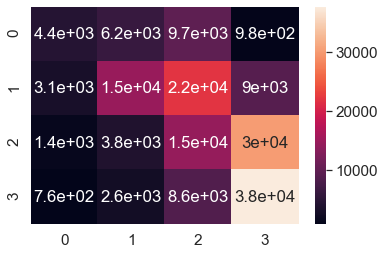

              precision    recall  f1-score   support

           0       0.46      0.21      0.29     21353
           1       0.54      0.30      0.39     48900
           2       0.26      0.29      0.28     50000
           3       0.48      0.76      0.59     49656

    accuracy                           0.42    169909
   macro avg       0.44      0.39      0.39    169909
weighted avg       0.43      0.42      0.40    169909



In [42]:
#Compute AUC score, Confusion matrix and Classification Report
def calculate_AUC(gmm, y_true, pred_to_actual):
    probs = gmm.predict_proba(X_new)
    
    #Binarize the output
    y_true = label_binarize(y_true, classes=np.arange(len(pred_to_actual)))
    
    #Rearrange probs
    idx = np.empty_like(pred_to_actual)
    idx[pred_to_actual] = np.arange(len(pred_to_actual))
    probs_r = probs[:, idx]

    auc_ovo1 = roc_auc_score(y_true, probs_r, average='weighted', multi_class='ovo')
    print("AUC average one-versus-one score: %.3f" % auc_ovo1)
    return auc_ovo1

calculate_AUC(gmm, X_reduced["year_bins"], pred_to_actual)

#Confusion Matrix 
df_cm = metrics.confusion_matrix(X_reduced['year_bins'],X_reduced['converted_labels'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True)
plt.show()

print(metrics.classification_report(X_reduced['year_bins'],X_reduced['converted_labels']))

### comparing to popularity_cut bins

In [35]:
#Find linear assignment of predicted clusters to actual bins
y_pred = gmm.predict(X_new)
y_true = X_reduced['popularity_cut']
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
_, pred_to_actual = linear_assignment(w.max() - w)
X_reduced['converted_labels'] = pred_to_actual[X_reduced['labels']]

AUC average one-versus-one score: 0.575


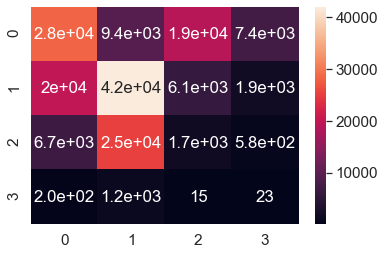

              precision    recall  f1-score   support

           0       0.51      0.44      0.47     64145
           1       0.54      0.60      0.57     69906
           2       0.06      0.05      0.06     34380
           3       0.00      0.02      0.00      1478

    accuracy                           0.42    169909
   macro avg       0.28      0.28      0.28    169909
weighted avg       0.43      0.42      0.42    169909



In [36]:
#Compute AUC score, Confusion matrix and Classification Report
def calculate_AUC(gmm, y_true, pred_to_actual):
    probs = gmm.predict_proba(X_new)
    
    #Binarize the output
    y_true = label_binarize(y_true, classes=np.arange(len(pred_to_actual)))
    
    #Rearrange probs
    idx = np.empty_like(pred_to_actual)
    idx[pred_to_actual] = np.arange(len(pred_to_actual))
    probs_r = probs[:, idx]

    auc_ovo1 = roc_auc_score(y_true, probs_r, average='weighted', multi_class='ovo')
    print("AUC average one-versus-one score: %.3f" % auc_ovo1)
    return auc_ovo1

calculate_AUC(gmm, X_reduced["popularity_cut"], pred_to_actual)

#Confusion Matrix 
df_cm = metrics.confusion_matrix(X_reduced['popularity_cut'],X_reduced['converted_labels'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True)
plt.show()

print(metrics.classification_report(X_reduced['popularity_cut'],X_reduced['converted_labels']))

### comparing to popularity_qcut

In [37]:
#Find linear assignment of predicted clusters to actual bins
y_pred = gmm.predict(X_new)
y_true = X_reduced['popularity_qcut']
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
_, pred_to_actual = linear_assignment(w.max() - w)
X_reduced['converted_labels'] = pred_to_actual[X_reduced['labels']]

AUC average one-versus-one score: 0.646


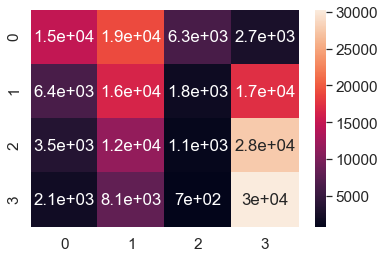

              precision    recall  f1-score   support

           0       0.55      0.35      0.43     42949
           1       0.30      0.39      0.34     42017
           2       0.11      0.03      0.04     43796
           3       0.39      0.74      0.51     41147

    accuracy                           0.37    169909
   macro avg       0.34      0.37      0.33    169909
weighted avg       0.34      0.37      0.32    169909



In [38]:
#Compute AUC score, Confusion matrix and Classification Report
def calculate_AUC(gmm, y_true, pred_to_actual):
    probs = gmm.predict_proba(X_new)
    
    #Binarize the output
    y_true = label_binarize(y_true, classes=np.arange(len(pred_to_actual)))
    
    #Rearrange probs
    idx = np.empty_like(pred_to_actual)
    idx[pred_to_actual] = np.arange(len(pred_to_actual))
    probs_r = probs[:, idx]

    auc_ovo1 = roc_auc_score(y_true, probs_r, average='weighted', multi_class='ovo')
    print("AUC average one-versus-one score: %.3f" % auc_ovo1)
    return auc_ovo1

calculate_AUC(gmm, X_reduced["popularity_qcut"], pred_to_actual)

#Confusion Matrix 
df_cm = metrics.confusion_matrix(X_reduced['popularity_qcut'],X_reduced['converted_labels'])
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True)
plt.show()

print(metrics.classification_report(X_reduced['popularity_qcut'],X_reduced['converted_labels']))